## Gerekli kütüphanelerin yüklenmesi

In [1]:
import os
import numpy as np
import string
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,  ConfusionMatrixDisplay,roc_curve, roc_auc_score,auc
from sklearn.metrics import RocCurveDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from wordcloud import WordCloud

## Veriyi okuma ve DataFrame'e dönüştürme

In [2]:
data = pd.read_csv('IMDB Dataset.csv')
df= data.copy()
df.shape

(50000, 2)

In [3]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


İki sütun halinde görüntülediğimiz veri setimizde istenmeyen noktalama ve analiz aşamasında işimize yaramayacak, eğitim kalitesini azaltacak gereksiz kelimeler bulunmakta. Bunlar ileriki aşamalarda temizlenecek ve ortaya daha duru bir veri seti çıkacaktır.

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Bu ifadede "top" en çok bulunan yorumu "freq" ise tüm veri setindeki en yaygın yorumun frekansını ifade eder. Yani bu durumda veri setinde top yorumdan 5 adet bulunduğunu anlayabiliriz. 49582 tane de benzersiz yorum vardır. 

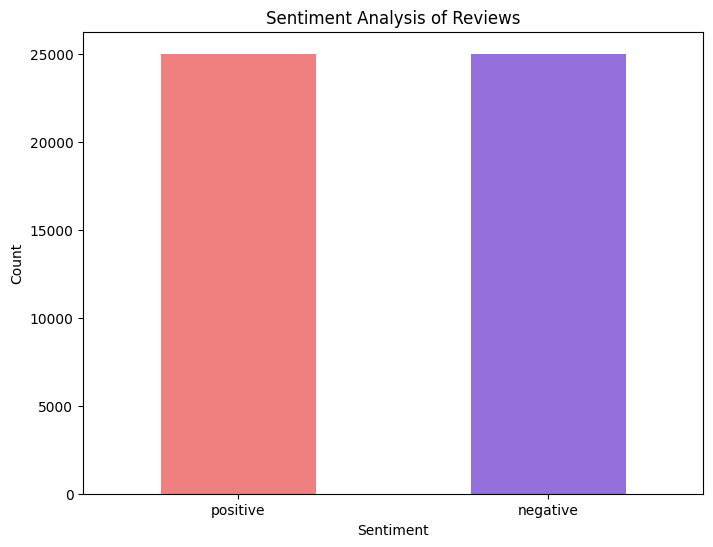

In [5]:
import matplotlib.pyplot as plt

#Her sentiment'in sayısını verir
sentiment_counts = df['sentiment'].value_counts()

#sentiment sayılarını çizdirir
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['lightcoral', 'mediumpurple'])
plt.title('Sentiment Analysis of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Veri Temizleme

In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Öncelikle null değerleri kontrol ettik ancak herhangi bir null değer bulunmuyor.

In [7]:
data.duplicated().sum()

418

In [8]:
data.drop_duplicates(inplace = True) #Tekrarlanan değerlerin silinmesi

In [9]:
df.sentiment = df.sentiment.map({ 'negative': 0, 'positive': 1 }) 
# Sentiment sütunundaki stringler sayısal değerlere dönüştürülür.
X = df.review.tolist()
y = df.sentiment.tolist() # Var olan iki sütun birer listeye dönüştürülür.

## Verinin eğitim ve test setlerine bölünmesi

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Ön İşleme Aşamaları

## Noktalama işaretlerinin temizlenmesi

In [11]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
# str.maketrans fonksiyonu ile noktalama işaretlerini boşluk karakterlerine dönüştüren bir tablo oluşturulur. 

## HTML etiketlerinin temizlenmesi

In [12]:
clean = re.compile(r'<[^>]+>')

In [13]:
X_train_clean = []
X_test_clean = []
for i, text in enumerate(X_train):
    text2 = text.lower()   # Küçük harfe çevirme
    text2 = text2.replace('\n', '')   #Tüm yeni satır ('\n') karakterlerini kaldırır
    text2 = clean.sub('', text2)   #html etiketlerini kaldırır
    text2 = text2.translate(translator)  #Noktalama işaretlerini boşluklarla değiştirme
    X_train_clean.append(text2)

for i, text in enumerate(X_test):
    text2 = text.lower()
    text2 = text2.replace('\n', '')
    text2 = clean.sub('', text2)
    text2 = text2.translate(translator)
    X_test_clean.append(text2)

X_train_clean = np.array(X_train_clean)
X_test_clean = np.array(X_test_clean)

X_train = X_train_clean
X_test = X_test_clean

X_train_copy = X_train.copy()
X_test_copy= X_test.copy()

In [14]:
X_train[0]

'this film has been compared to the hilarious british comedy  a fish called wanda   although i can t see why  the only connection i can find is the monty python one  eric idle in  nuns   john cleese and michael palin in  wanda    otherwise the two are incomparable idle and robbie coltrane are two gangsters who want to get out of the business before they end up dead  so they decide to rip off their boss and make for rio  when the getaway goes wrong  the two are forced to take refuge in a convent  as nuns what at first promises to be a riot soon becomes a predictable  average movie with the usual tasteless sex jokes and bland humour  once again there are the occasional high spots  but neither cast nor crew manage to inspire proceedings  an attempt at a  wanda  type manic finish fails too  along with the effort at  men in drag  humour  which is hardly surprising  when you think about it  men trying to be women is funny  men trying to be nuns is ridiculous friday  april 22  1994   video'

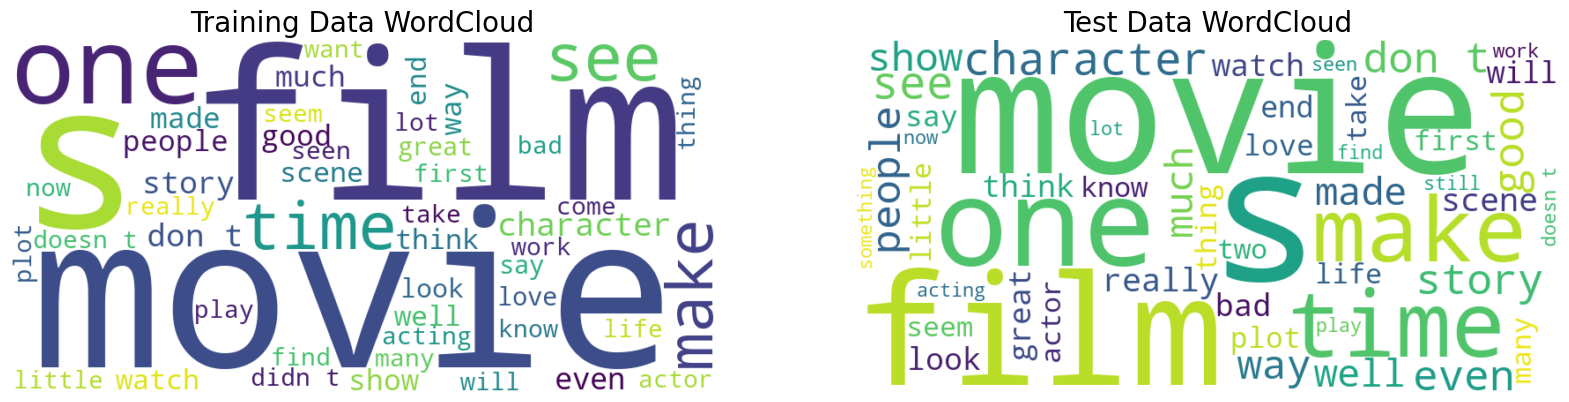

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Tüm metinleri birleştir
train_text = " ".join(X_train)
test_text = " ".join(X_test)

# WordCloud oluşturma fonksiyonu
def generate_wordcloud(text, max_words=50, title=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)

# Kelime bulutlarını yan yana çizme
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Eğitim verileri kelime bulutu
axs[0].imshow(WordCloud(width=800, height=400, background_color='white', max_words=50).generate(train_text), interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Training Data WordCloud', fontsize=20)

# Test verileri kelime bulutu
axs[1].imshow(WordCloud(width=800, height=400, background_color='white', max_words=50).generate(test_text), interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Test Data WordCloud', fontsize=20)

plt.show()

## Tokenization işlemi

In [16]:
top_words = 15000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train) #Tokenizer nesnesi, X_train veri kümesi üzerinde eğitilir.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) # Veri kümelerindeki metinler, Tokenizer nesnesi tarafından sayısal dizilere dönüştürülür. 

## Padding işlemi

In [17]:
from tensorflow.keras.preprocessing import sequence
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_words, padding='post')
# 'pad_sequences' çeşitli uzunluktaki metin dizilerini aynı uzunluğa getirerek, bunları sabit boyutlu tensörlere dönüştürmek için kullanılır. 

In [18]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Model kurulumu

In [19]:
model = Sequential()
model.add(Embedding(top_words,64, input_length=max_words))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(32,5,activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=32, verbose=1)

Epoch 1/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 441s 351ms/step - accuracy: 0.4988 - loss: 0.6959 - val_accuracy: 0.4956 - val_loss: 0.6818
Epoch 2/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 524s 419ms/step - accuracy: 0.5729 - loss: 0.6728 - val_accuracy: 0.7504 - val_loss: 0.5491
Epoch 3/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 469s 375ms/step - accuracy: 0.6841 - loss: 0.5933 - val_accuracy: 0.5692 - val_loss: 0.6799
Epoch 4/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 437s 350ms/step - accuracy: 0.7645 - loss: 0.5080 - val_accuracy: 0.8912 - val_loss: 0.2567
Epoch 5/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 417s 334ms/step - accuracy: 0.9039 - loss: 0.2485 - val_accuracy: 0.9053 - val_loss: 0.2461
Epoch 6/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 423s 338ms/step - accuracy: 0.9315 - loss: 0.1911 - val_accuracy: 0.9132 - val_loss: 0.2208
Epoch 7/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 465s 372ms/step - accuracy: 0.9494 - loss: 0.1468 - val_accuracy: 0.9140 - val_loss: 0.2517
Epoch 8/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 425s 340ms/step - ac

In [22]:
model.save('my_model.h5')

#### Eğitim sırasında elde edilen değerlerle doğruluk(accuracy) ve kayıp(loss) grafiği

In [23]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

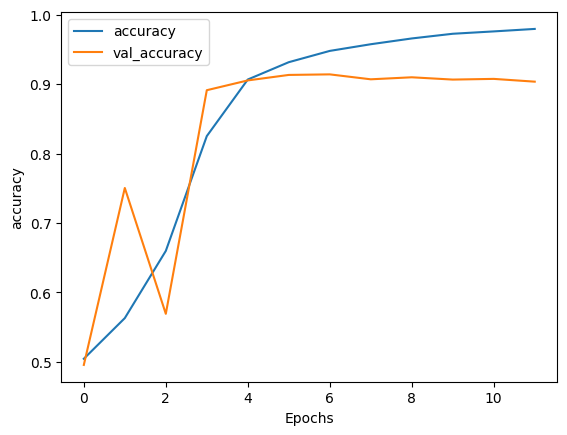

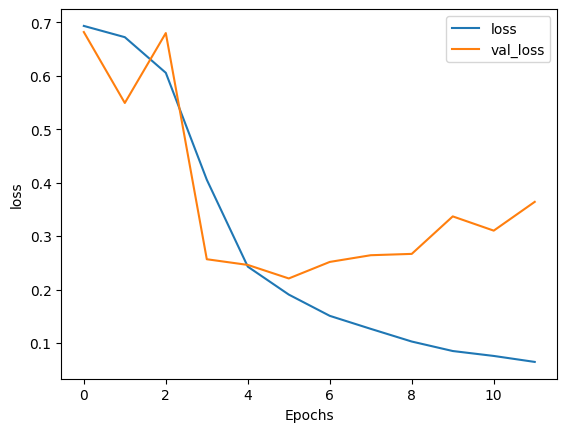

In [24]:
plot_history(history, "accuracy")
plot_history(history, "loss")

In [25]:
print("Modelin test seti üzerindeki performansı:")
result = model.evaluate(X_test,y_test)
print(dict(zip(model.metrics_names, result)))

Modelin test seti üzerindeki performansı:
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.9081 - loss: 0.3551
{'loss': 0.3640916645526886, 'compile_metrics': 0.9035000205039978}


## Modelin veri setinden farklı örneklerle denenmesi

In [43]:
def read_file(filename):
  lines = []
  with open(filename, 'r') as file:
    for line in file:
      lines.append(line.strip())
  return lines

In [59]:
neg = read_file('negative.txt')

In [60]:
neg_list = []
clean = re.compile(r'<[^>]+>')
for i, text in enumerate(neg):
    tmp_text = text.lower()
    tmp_text = tmp_text.replace('\n', '')
    tmp_text = clean.sub('', tmp_text)
    tmp_text = tmp_text.translate(translator)
    neg_list.append(tmp_text)

neg_list = np.array(neg_list)

In [61]:
neg_list = tokenizer.texts_to_sequences(neg_list)
neg_list = sequence.pad_sequences(neg_list, maxlen=max_words, padding='post')
prediction = model.predict(neg_list)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [62]:
count_below_05 = np.sum(prediction < 0.5)
count_above_05 = np.sum(prediction >= 0.5)

print(f"negative: {count_below_05}")
print(f"positive: {count_above_05}")

negative: 95
positive: 5


In [67]:
pos = read_file("positive.txt")

In [68]:
pos_list = []
clean = re.compile(r'<[^>]+>')
for i, text in enumerate(pos):
    tmp_text = text.lower()
    tmp_text = tmp_text.replace('\n', '')
    tmp_text = clean.sub('', tmp_text)
    tmp_text = tmp_text.translate(translator)
    pos_list.append(tmp_text)

pos_list = np.array(pos_list)

In [69]:
pos_list = tokenizer.texts_to_sequences(pos_list)
pos_list = sequence.pad_sequences(pos_list, maxlen=max_words, padding='post')
prediction = model.predict(pos_list)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 


In [70]:
count_below_05 = np.sum(prediction < 0.5)
count_above_05 = np.sum(prediction >= 0.5)

# Sonuçları ekrana yazdırma
print(f"negative: {count_below_05}")
print(f"positive: {count_above_05}")

negative: 16
positive: 84
